## Imports & All of Texas Data

In [2]:
### SECTION 0: Imports + data

import geopandas as gpd
import networkx as nx
import pickle
import matplotlib.pyplot as plt
from shapely.geometry import box, Point, LineString
import pandas as pd
import numpy as np
import random
import time
import os

SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)

# 0.1 Load road shapefile
roads = gpd.read_file("gis_osm_roads_free_1.shp")

major_classes = [
    "motorway", "trunk", "primary", "secondary", "tertiary",
    "motorway_link", "trunk_link", "primary_link",
    "secondary_link", "tertiary_link",
    "residential", "unclassified", "living_street"
]

roads_major = roads[roads["fclass"].isin(major_classes)]
print(len(roads_major), "major road segments in Texas")

# 0.2 Load statewide time-weighted directed graph (already EPSG:3857)
with open("texas_roads.pkl", "rb") as f:
    G = pickle.load(f)

print("Statewide graph:", G.number_of_nodes(), "nodes,", G.number_of_edges(), "edges")


1275397 major road segments in Texas
Statewide graph: 5828743 nodes, 7024931 edges


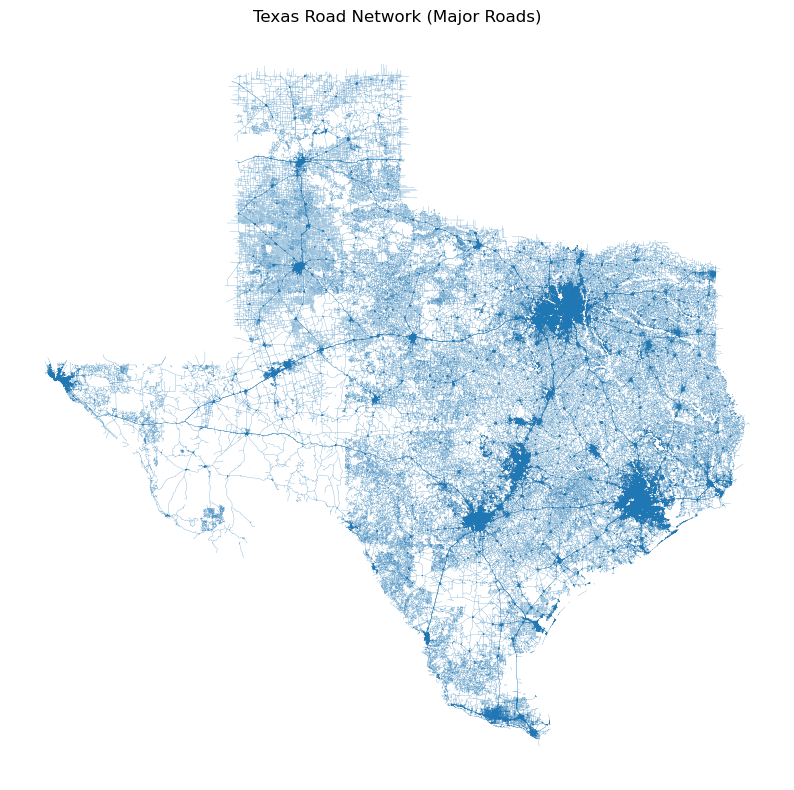

In [3]:
#Entire Texas:
# Use the same 'roads_major' from earlier
roads_tx_proj = roads_major.to_crs(epsg=3857)

fig, ax = plt.subplots(figsize=(10, 10))
roads_tx_proj.plot(ax=ax, linewidth=0.15)
ax.set_title("Texas Road Network (Major Roads)")
ax.set_axis_off()
plt.show()

## Leander & Cedar Park - Question 1 Analysis

#### Maps

14505 road segments in Leander + Cedar Park


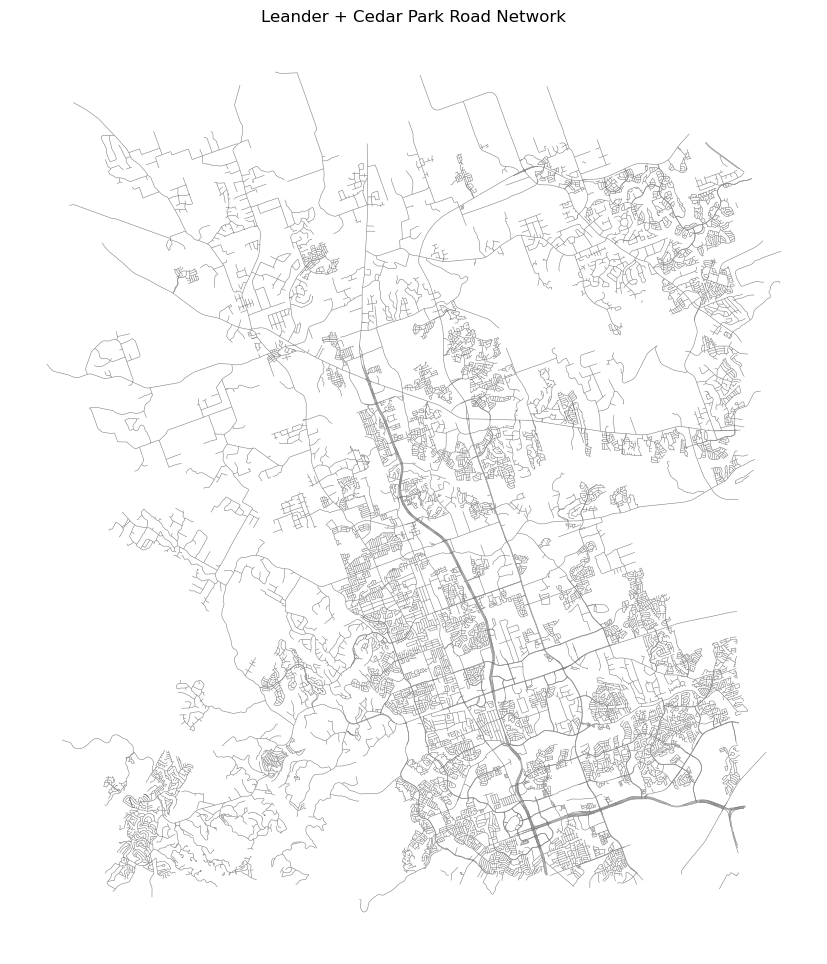

Leander + Cedar Park bbox in EPSG:3857: -10912670.410153793 -10873493.507987987 3559471.498539673 3604291.6463674316
Leander + Cedar Park node count: 123453
Largest CC (CP+Lea): 8941 nodes, 14802 edges
Merged CP+Lea graph: 8499 nodes, 14105 edges


In [6]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import networkx as nx
import pandas as pd
import random

# --- 0.1 Leander + Cedar Park bounding box in WGS84 ---
cedar_lea_bbox = (-98.00, -97.70, 30.45, 30.75)  # (minx, maxx, miny, maxy) in lon/lat

# Filter *roads* by bbox (WGS84)
cp_lea_roads = roads_major.cx[
    cedar_lea_bbox[0]:cedar_lea_bbox[1],
    cedar_lea_bbox[2]:cedar_lea_bbox[3]
]

print(len(cp_lea_roads), "road segments in Leander + Cedar Park")

# Project to 3857 for plotting & bounds
cp_lea_proj = cp_lea_roads.to_crs(epsg=3857)

# Quick map
fig, ax = plt.subplots(figsize=(12, 12))
cp_lea_proj.plot(ax=ax, linewidth=0.4, color="gray")
ax.set_title("Leander + Cedar Park Road Network")
ax.set_axis_off()
plt.show()

# --- 0.2 Subset the statewide graph G using the same projected bounds ---

x_min, y_min, x_max, y_max = cp_lea_proj.total_bounds
print("Leander + Cedar Park bbox in EPSG:3857:", x_min, x_max, y_min, y_max)

cp_lea_nodes = [
    n for n in G.nodes
    if x_min <= n[0] <= x_max and y_min <= n[1] <= y_max
]

print("Leander + Cedar Park node count:", len(cp_lea_nodes))

G_cp_lea = G.subgraph(cp_lea_nodes).copy()
#print("Raw CP+Lea subgraph:", G_cp_lea.number_of_nodes(), "nodes,", G_cp_lea.number_of_edges(), "edges")

# --- 0.3 Keep largest weakly connected component ---
components = list(nx.weakly_connected_components(G_cp_lea))
largest = max(components, key=len)
G_cp_lea_cc = G_cp_lea.subgraph(largest).copy()

print("Largest CC (CP+Lea):", G_cp_lea_cc.number_of_nodes(), "nodes,", G_cp_lea_cc.number_of_edges(), "edges")

# --- 0.4 Snap/merge nearby nodes (e.g., 15 m) to clean intersections ---

snap = 15.0  # meters

nodes_df = pd.DataFrame(list(G_cp_lea_cc.nodes()), columns=["x", "y"])
nodes_df["x_snap"] = (nodes_df["x"] / snap).round() * snap
nodes_df["y_snap"] = (nodes_df["y"] / snap).round() * snap

mapping = {
    (row.x, row.y): (row.x_snap, row.y_snap)
    for row in nodes_df.itertuples(index=False)
}

G_cp_lea_merged = nx.DiGraph()

for u, v, data in G_cp_lea_cc.edges(data=True):
    u2 = mapping[u]
    v2 = mapping[v]
    if u2 == v2:
        continue

    if G_cp_lea_merged.has_edge(u2, v2):
        existing_tt = G_cp_lea_merged[u2][v2].get("travel_time_s", float("inf"))
        new_tt = data.get("travel_time_s", existing_tt)
        if new_tt < existing_tt:
            G_cp_lea_merged[u2][v2].update(data)
    else:
        G_cp_lea_merged.add_edge(u2, v2, **data)

print("Merged CP+Lea graph:", G_cp_lea_merged.number_of_nodes(), "nodes,",
      G_cp_lea_merged.number_of_edges(), "edges")

# Roads in 3857 for joins (we’ll reuse this a lot)
roads_3857 = cp_lea_roads.to_crs(epsg=3857)


- Line 1: The bounding box coordinates for Leander and Cedar Park
- Line 2 (123453 Nodes): total number of nodes returned inside your bounding box. Includes irrelevant nodes from waterways, footpaths, dead ends, driveway points, parking lots, etc. 
- Line 3 (8941 Nodes): Filtered out irrelevant networks. The largest connected road network contained 8941 Nodes and 14802 edges. 
- Line 4 (8499 Nodes): Employ edge merging where long roads with many mid-block shape nodes get turned into single edges and parallel overlapping geometries get merged.

14505 road segments in Leander + Cedar Park


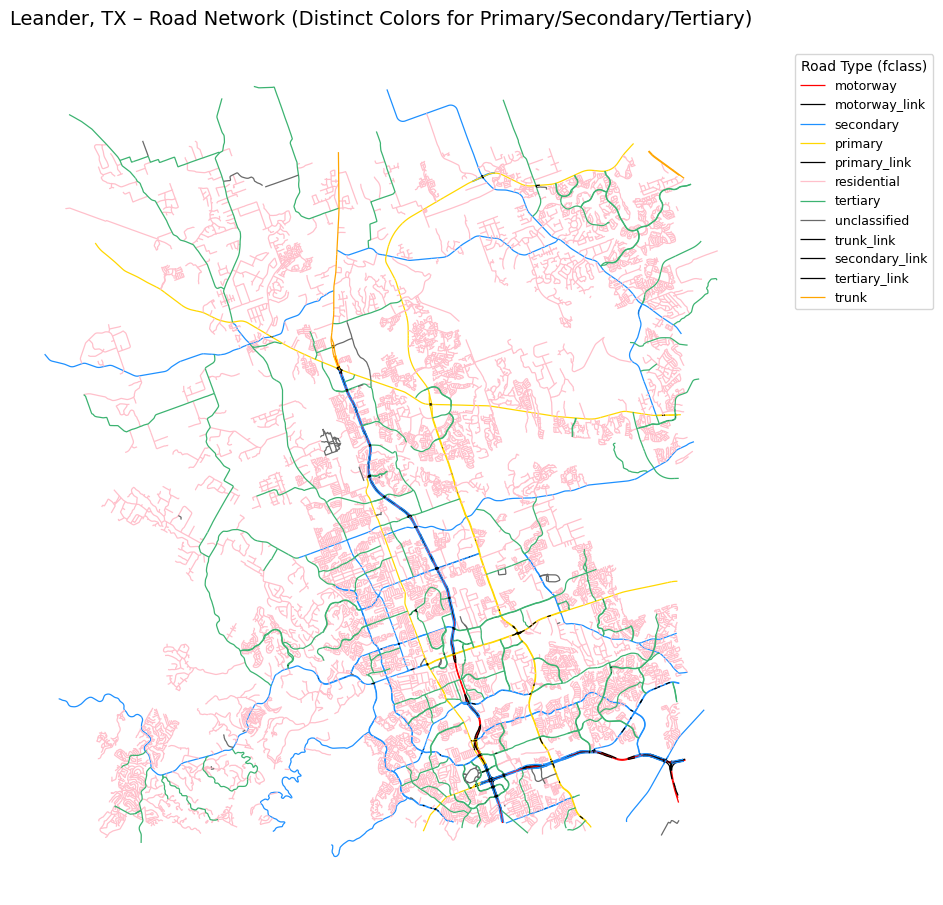

In [8]:
# --- Leander + Cedar Park bounding box ---
cedar_lea_bbox = (-98.00, -97.70, 30.45, 30.75)

# Filter roads by bbox (still in WGS84 here)
cp_lea_roads = roads_major.cx[
    cedar_lea_bbox[0]:cedar_lea_bbox[1],
    cedar_lea_bbox[2]:cedar_lea_bbox[3]
]

print(len(cp_lea_roads), "road segments in Leander + Cedar Park")

# Project to 3857 for plotting
cp_lea_proj = cp_lea_roads.to_crs(epsg=3857)

# CUSTOM color palette
color_map = {
    "motorway": "red",
    "trunk": "orange",
    "primary": "gold",
    "secondary": "dodgerblue",
    "tertiary": "mediumseagreen",
    
    # Minor roads
    "residential": "pink",
    "unclassified": "dimgray",
    "living_street": "lightgray",
    "service": "lightgray",
    
    # Tracks
    "track": "saddlebrown",
    "track_grade1": "saddlebrown",
    "track_grade2": "sienna",
    "track_grade3": "peru",
    "track_grade4": "tan",
    "track_grade5": "wheat",

    # Walking/bike
    "cycleway": "purple",
    "footway": "forestgreen",
    "path": "darkgreen",
    "bridleway": "darkcyan",
}

# fallback color if type not in dict
default_color = "black"

# Determine unique road classes
road_types = cp_lea_proj["fclass"].unique()

# Plot
fig, ax = plt.subplots(figsize=(11, 11))

for rtype in road_types:
    subset = cp_lea_proj[cp_lea_proj["fclass"] == rtype]
    clr = color_map.get(rtype, default_color)
    subset.plot(ax=ax, color=clr, linewidth=0.9, label=rtype)

ax.set_title("Leander, TX – Road Network (Distinct Colors for Primary/Secondary/Tertiary)", fontsize=14)
ax.set_axis_off()

# Legend outside the map
ax.legend(
    title="Road Type (fclass)",
    loc="upper left",
    bbox_to_anchor=(1.05, 1),
    fontsize=9
)

plt.show()


#### Mid-Node Merging

In [10]:
import networkx as nx

def simplify_road_graph(G, weight_keys=("travel_time_s",)):
    """
    Simplify a directed road graph by removing mid-segment nodes.

    - Uses an undirected view to find chains of degree-2 nodes.
    - Keeps nodes whose undirected degree != 2 (intersections, dead-ends).
    - Along chains of degree-2 nodes, replaces many small edges with one
      longer edge for each direction that exists.
    - Sums weights in `weight_keys` (e.g., travel_time_s) along the chain.
    """

    # Undirected view for topology
    H = G.to_undirected()

    # Nodes we keep as vertices in simplified graph (true intersections / dead-ends)
    endpoints = {n for n in H.nodes if H.degree(n) != 2}

    # New simplified directed graph
    G_simpl = nx.DiGraph()
    G_simpl.add_nodes_from(endpoints)

    visited_undirected = set()

    def undirected_edge_key(a, b):
        # normalise an undirected edge key
        return (a, b) if a <= b else (b, a)

    for u in endpoints:
        for v in H.neighbors(u):
            key = undirected_edge_key(u, v)
            if key in visited_undirected:
                continue

            # ---------- Build undirected path u -> ... -> w ----------
            path = [u, v]
            prev = u
            cur = v

            while H.degree(cur) == 2 and cur not in endpoints:
                # exactly two neighbors in H, one is prev, the other is nxt
                neighs = [n for n in H.neighbors(cur) if n != prev]
                if not neighs:
                    break
                nxt = neighs[0]
                path.append(nxt)
                prev, cur = cur, nxt

            # Mark all undirected edges in this path as visited
            for a, b in zip(path[:-1], path[1:]):
                visited_undirected.add(undirected_edge_key(a, b))

            seg_start = path[0]
            seg_end = path[-1]

            # ---------- Build simplified edges for each direction ----------

            # Helper to aggregate attributes along the path for direction a->b
            def aggregate_direction(forward=True):
                first_data = None
                sums = {k: 0.0 for k in weight_keys}
                name_val = None

                # choose edge orientation
                pairs = zip(path[:-1], path[1:])
                if not forward:
                    pairs = zip(path[1:], path[:-1])

                has_any = False

                for a, b in pairs:
                    if G.has_edge(a, b):
                        data = G[a][b]
                        has_any = True
                        if first_data is None:
                            first_data = data.copy()
                            name_val = data.get("name")
                        for k in weight_keys:
                            if k in data:
                                sums[k] += data[k]

                if not has_any or first_data is None:
                    return None

                # sum weights
                for k, val in sums.items():
                    if val != 0.0:
                        first_data[k] = val
                if name_val is not None:
                    first_data["name"] = name_val

                return first_data

            # forward direction seg_start -> seg_end
            data_fwd = aggregate_direction(forward=True)
            if data_fwd is not None:
                if G_simpl.has_edge(seg_start, seg_end):
                    old = G_simpl[seg_start][seg_end]
                    if data_fwd.get("travel_time_s", 1e18) < old.get("travel_time_s", 1e18):
                        old.update(data_fwd)
                else:
                    G_simpl.add_edge(seg_start, seg_end, **data_fwd)

            # backward direction seg_end -> seg_start
            data_back = aggregate_direction(forward=False)
            if data_back is not None:
                if G_simpl.has_edge(seg_end, seg_start):
                    old = G_simpl[seg_end][seg_start]
                    if data_back.get("travel_time_s", 1e18) < old.get("travel_time_s", 1e18):
                        old.update(data_back)
                else:
                    G_simpl.add_edge(seg_end, seg_start, **data_back)

    return G_simpl


In [11]:
print("Original merged graph:",
      G_cp_lea_merged.number_of_nodes(), "nodes,",
      G_cp_lea_merged.number_of_edges(), "edges")

G_cp_lea_simpl = simplify_road_graph(G_cp_lea_merged)

print("Simplified graph:",
      G_cp_lea_simpl.number_of_nodes(), "nodes,",
      G_cp_lea_simpl.number_of_edges(), "edges")


Original merged graph: 8499 nodes, 14105 edges
Simplified graph: 4706 nodes, 8724 edges


In [12]:
import collections

deg_counts = collections.Counter(dict(G_cp_lea_simpl.to_undirected().degree()).values())
print("Degree histogram (undirected):")
for d, count in sorted(deg_counts.items()):
    print(f"  degree {d}: {count} nodes")


Degree histogram (undirected):
  degree 1: 1920 nodes
  degree 2: 61 nodes
  degree 3: 1709 nodes
  degree 4: 904 nodes
  degree 5: 95 nodes
  degree 6: 17 nodes


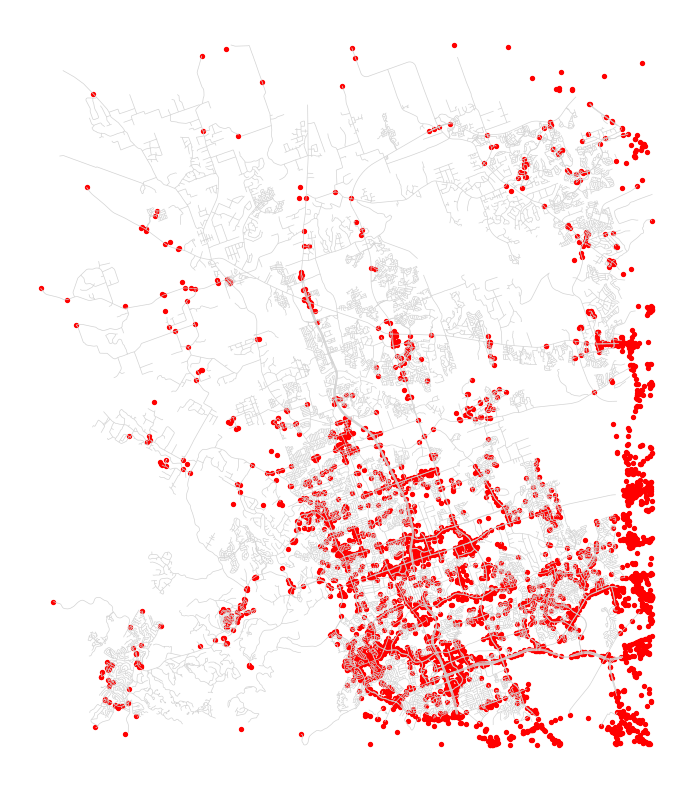

In [13]:
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt

gdf_nodes_simpl = gpd.GeoDataFrame(
    geometry=[Point(xy) for xy in G_cp_lea_simpl.nodes()],
    crs="EPSG:3857"
)

fig, ax = plt.subplots(figsize=(10, 10))
cp_lea_proj.plot(ax=ax, color="lightgray", linewidth=0.5)
gdf_nodes_simpl.plot(ax=ax, color="red", markersize=8)

ax.set_axis_off()
plt.show()


#### Question 1 - Central Hubs (Instersections)

In [15]:
#### updateed
# ==========================
# Q1: Central hubs in CP+Lea
# (using simplified graph)
# ==========================

print("Computing degree centrality on simplified graph...")
deg = nx.degree_centrality(G_cp_lea_simpl)

print("Computing closeness centrality (travel time, simplified)...")
clo = nx.closeness_centrality(
    G_cp_lea_simpl,
    distance="travel_time_s"
)

print("Computing betweenness centrality (sampled, travel time, simplified)...")
btw = nx.betweenness_centrality(
    G_cp_lea_simpl,
    k=min(500, G_cp_lea_simpl.number_of_nodes()),
    weight="travel_time_s",
    seed=SEED
)

# Combine into one table
centrality_df = pd.DataFrame({
    "node": list(G_cp_lea_simpl.nodes())
})
centrality_df["degree"] = centrality_df["node"].map(deg)
centrality_df["closeness"] = centrality_df["node"].map(clo)
centrality_df["betweenness"] = centrality_df["node"].map(btw)

# Normalized z-scores
for col in ["degree", "closeness", "betweenness"]:
    mu = centrality_df[col].mean()
    sd = centrality_df[col].std() if centrality_df[col].std() > 0 else 1.0
    centrality_df[col + "_z"] = (centrality_df[col] - mu) / sd

centrality_df["centrality_score"] = (
    centrality_df["degree_z"] +
    centrality_df["closeness_z"] +
    centrality_df["betweenness_z"]
)

centrality_df.sort_values("centrality_score", ascending=False, inplace=True)

# Helper (reuse your existing one if already defined)
def get_street_names(point, roads_gdf, radius=30):
    buf = point.buffer(radius)
    nearby = roads_gdf[roads_gdf.intersects(buf)]
    names = sorted(set(nearby["name"].dropna()))
    if not names:
        return "Unnamed road"
    if len(names) > 3:
        names = names[:3]
    return " & ".join(names)

# Attach labels for top-k hubs (take more, then dedupe)
top_k = 50
top_hubs = centrality_df.head(top_k).copy()

gdf_hubs = gpd.GeoDataFrame(
    top_hubs,
    geometry=[Point(xy) for xy in top_hubs["node"]],
    crs="EPSG:3857"
)

gdf_hubs = gpd.sjoin_nearest(
    gdf_hubs,
    roads_3857[["name", "geometry"]],
    how="left",
    distance_col="dist_nearest",
    max_distance=50
)
gdf_hubs["road_name"] = gdf_hubs["name"].fillna("Unnamed road")
gdf_hubs.drop(columns=["name"], inplace=True)

gdf_hubs["intersection_names"] = gdf_hubs.geometry.apply(
    lambda p: get_street_names(p, roads_3857, radius=30)
)

# De-duplicate: keep the most central node per intersection name
gdf_hubs_unique = (
    gdf_hubs
    .sort_values("centrality_score", ascending=False)
    .drop_duplicates(subset="intersection_names")
)

central_hub_table = gdf_hubs_unique[
    ["intersection_names", "road_name", "degree", "closeness",
     "betweenness", "centrality_score"]
].sort_values("centrality_score", ascending=False)

central_hub_table.head(10)


Computing degree centrality on simplified graph...
Computing closeness centrality (travel time, simplified)...
Computing betweenness centrality (sampled, travel time, simplified)...


,intersection_names,road_name,degree,closeness,betweenness,centrality_score
637,Cypress Creek Road & East Cypress Creek Road &...,Unnamed road,0.001700,0.001409,0.113983,9.676329
3088,East Whitestone Boulevard & Ronald W Reagan Bo...,East Whitestone Boulevard,0.000850,0.001505,0.141439,9.550720
2122,East Whitestone Boulevard,East Whitestone Boulevard,0.001700,0.001263,0.092627,7.962631
3937,Cottonwood Creek Trail & East Whitestone Boule...,East Whitestone Boulevard,0.001275,0.001471,0.093496,7.623073
4418,183A Frontage Road & East Whitestone Boulevard,East Whitestone Boulevard,0.000850,0.001504,0.107317,7.519136
4265,Walton Way & West Whitestone Boulevard,West Whitestone Boulevard,0.001700,0.001414,0.077102,7.500876
4299,Bagdad Road & West Whitestone Boulevard,Bagdad Road,0.001275,0.001373,0.094148,7.362250
3152,East Whitestone Boulevard & North Bell Bouleva...,West Whitestone Boulevard,0.000850,0.001385,0.107715,7.180961
306,East Whitestone Boulevard & Mayfield Ranch Bou...,East Whitestone Boulevard,0.001275,0.001271,0.096133,7.170884
1235,Cypress Creek Road,Unnamed road,0.001913,0.001276,0.068938,7.107778


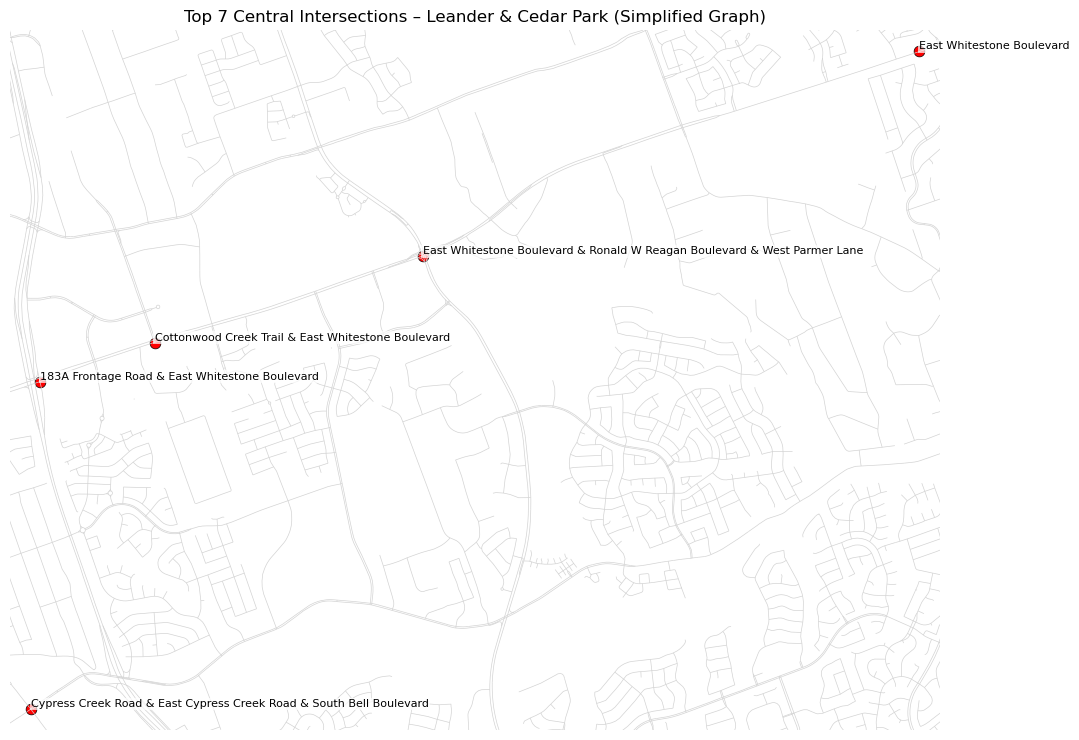

In [16]:
# --- Plot top 7 central intersections on the road map ---

gdf_hubs_sorted = gdf_hubs_unique.sort_values("centrality_score", ascending=False)
top7 = gdf_hubs_sorted.head(5).copy()

fig, ax = plt.subplots(figsize=(12, 12))

cp_lea_proj.plot(ax=ax, color="lightgray", linewidth=0.5)

top7.plot(
    ax=ax,
    color="red",
    markersize=60,
    edgecolor="black",
    linewidth=0.5
)

for _, row in top7.iterrows():
    x = row.geometry.x
    y = row.geometry.y
    label = row["intersection_names"]
    ax.text(
        x, y,
        label,
        fontsize=8,
        ha="left",
        va="bottom",
        color="black",
        bbox=dict(facecolor="white", edgecolor="none", alpha=0.7, pad=1.0)
    )

minx, miny, maxx, maxy = top7.total_bounds
pad = 200
ax.set_xlim(minx - pad, maxx + pad)
ax.set_ylim(miny - pad, maxy + pad)

ax.set_title("Top 7 Central Intersections – Leander & Cedar Park (Simplified Graph)")
ax.set_axis_off()

plt.show()


## Leander & Cedar Park - Question 2 Analysis

#### Helper functions

In [19]:
import random

def sample_pairs(G, n_pairs=3000, seed=SEED):
    random.seed(seed)
    nodes = sorted(G.nodes())
    if len(nodes) < 2:
        raise ValueError("Graph must have at least 2 nodes.")
    return [tuple(random.sample(nodes, 2)) for _ in range(n_pairs)]

def approximate_efficiency_from_pairs(G, pairs, weight="travel_time_s"):
    inv_d_sum = 0.0
    count = 0

    for u, v in pairs:
        # ⬇️ Skip pairs involving nodes that are gone (after removals)
        if (u not in G) or (v not in G):
            continue

        try:
            d = nx.shortest_path_length(G, u, v, weight=weight)
            if d > 0:
                inv_d_sum += 1.0 / d
                count += 1
        except nx.NetworkXNoPath:
            # disconnected after removals
            continue

    return inv_d_sum / count if count > 0 else 0.0


#### Node Closure - Which nodes should we protect from closure?
What is the efficiency drop when the top nodes are individually removed?

In [21]:
# ========= Node closure impact (simplified graph) =========
t0 = time.perf_counter()

pairs_for_nodes = sample_pairs(G_cp_lea_simpl, n_pairs=3000, seed=SEED)

E_base_approx_nodes = approximate_efficiency_from_pairs(
    G_cp_lea_simpl, pairs_for_nodes, weight="travel_time_s"
)
print("Baseline approximate efficiency (nodes):", E_base_approx_nodes)

def node_closure_impact_with_intersection_names(
    G,
    btw,
    E_base,
    roads_3857,
    pairs,
    k=10,
    weight="travel_time_s"
):
    top_nodes = sorted(btw.items(), key=lambda x: x[1], reverse=True)[:k]
    results = []

    for node, bscore in top_nodes:
        G_tmp = G.copy()
        if node in G_tmp:
            G_tmp.remove_node(node)
        else:
            results.append((node, bscore, None, None))
            continue

        E_after = approximate_efficiency_from_pairs(G_tmp, pairs, weight=weight)
        drop_pct = (E_base - E_after) / E_base * 100 if E_base > 0 else 0.0

        results.append((node, bscore, E_after, drop_pct))

    df = pd.DataFrame(
        results,
        columns=["node", "betweenness", "efficiency_after", "eff_drop_pct"]
    )

    gdf_nodes = gpd.GeoDataFrame(
        df,
        geometry=[Point(xy) for xy in df["node"]],
        crs="EPSG:3857"
    )

    joined = gpd.sjoin_nearest(
        gdf_nodes,
        roads_3857[["name", "geometry"]],
        how="left",
        distance_col="dist_nearest",
        max_distance=50
    )
    joined["road_name"] = joined["name"].fillna("Unnamed road")
    joined = joined.drop(columns=["name"])

    joined["intersection_names"] = joined.geometry.apply(
        lambda p: get_street_names(p, roads_3857, radius=30)
    )

    return joined

# Use betweenness from Q1 (on simplified graph)
node_impact_cp_lea = node_closure_impact_with_intersection_names(
    G_cp_lea_simpl,
    btw,
    E_base_approx_nodes,
    roads_3857,
    pairs_for_nodes,
    k=10
)

# De-duplicate by intersection name
node_impact_unique = (
    node_impact_cp_lea
    .sort_values("eff_drop_pct", ascending=False)
    .drop_duplicates(subset="intersection_names")
)

node_impact_unique_table = node_impact_unique[
    ["intersection_names", "road_name", "betweenness", "eff_drop_pct"]
].sort_values("eff_drop_pct", ascending=False)

t1 = time.perf_counter()
print(f"Centrality section took {t1 - t0:.2f} seconds")

node_impact_unique_table.head(7)


Baseline approximate efficiency (nodes): 0.0016352715865041749
Centrality section took 53.15 seconds


,intersection_names,road_name,betweenness,eff_drop_pct
7,East Whitestone Boulevard,East Whitestone Boulevard,0.103167,1.697070
3,East Whitestone Boulevard & Ronald W Reagan Bo...,Ronald W Reagan Boulevard,0.121000,1.468176
9,Royal Vista Boulevard,Unnamed road,0.097985,1.267445
6,183A Frontage Road & East Whitestone Boulevard,East Whitestone Boulevard,0.107317,1.218956
4,Cypress Creek Road & East Cypress Creek Road &...,Unnamed road,0.113983,1.086895
5,East Whitestone Boulevard & North Bell Bouleva...,West Whitestone Boulevard,0.107715,0.816529


#### Edge Closures - Which edges should we protect from closure?
What is the efficiency drop when the top edges are individually removed?

In [23]:
# ========= Edge betweenness + closure impact (simplified graph) =========
import time
t0 = time.perf_counter()

print("Computing edge betweenness centrality (simplified graph)...")

edge_btw = nx.edge_betweenness_centrality(
    G_cp_lea_simpl,
    k=min(3000, G_cp_lea_simpl.number_of_nodes()),
    weight="travel_time_s",
    seed=SEED
)

print("Approximating baseline efficiency for edges...")
pairs_for_edges = sample_pairs(G_cp_lea_simpl, n_pairs=4000, seed=SEED)
E_base_edges = approximate_efficiency_from_pairs(
    G_cp_lea_simpl, pairs_for_edges, weight="travel_time_s"
)
print("Baseline approximate efficiency (edges):", E_base_edges)

def edge_closure_impact_with_roadname(
    G,
    edge_btw,
    E_base,
    roads_3857,
    pairs,
    k=10
):
    top_items = sorted(edge_btw.items(), key=lambda x: x[1], reverse=True)[:k]
    top_edges = [e for e, _ in top_items]
    top_scores = [b for _, b in top_items]

    midpoints = [
        Point((u[0] + v[0]) / 2, (u[1] + v[1]) / 2)
        for (u, v) in top_edges
    ]
    gdf_mid = gpd.GeoDataFrame(
        {"edge": top_edges, "betweenness": top_scores},
        geometry=midpoints,
        crs="EPSG:3857"
    )

    joined = gpd.sjoin_nearest(
        gdf_mid,
        roads_3857[["name", "geometry"]],
        how="left",
        distance_col="dist",
        max_distance=50
    )

    results = []
    for idx, row in joined.iterrows():
        (u, v) = row["edge"]
        bscore = row["betweenness"]
        road_name = row.get("name")
        if not isinstance(road_name, str) or not road_name:
            road_name = "Unknown road"

        G_tmp = G.copy()
        if G_tmp.has_edge(u, v):
            G_tmp.remove_edge(u, v)
            E_after = approximate_efficiency_from_pairs(
                G_tmp, pairs, weight="travel_time_s"
            )
            drop_pct = (E_base - E_after) / E_base * 100 if E_base > 0 else None
        else:
            E_after = None
            drop_pct = None

        results.append(((u, v), bscore, E_after, drop_pct, road_name))

    df = pd.DataFrame(
        results,
        columns=["edge", "betweenness", "efficiency_after", "eff_drop_pct", "road_name"]
    )

    df_gdf = gpd.GeoDataFrame(
        df,
        geometry=[
            Point((u[0] + v[0]) / 2, (u[1] + v[1]) / 2)
            for (u, v) in df["edge"]
        ],
        crs="EPSG:3857"
    )

    return df_gdf

edge_impact_cp_lea = edge_closure_impact_with_roadname(
    G_cp_lea_simpl,
    edge_btw,
    E_base_edges,
    roads_3857,
    pairs_for_edges,
    k=50
)

edge_table = (
    edge_impact_cp_lea[["road_name", "betweenness", "efficiency_after", "eff_drop_pct"]]
    .sort_values("eff_drop_pct", ascending=False)
    .reset_index(drop=True)
)

t1 = time.perf_counter()
print(f"Centrality section took {t1 - t0:.2f} seconds")

edge_table.head(10)


Computing edge betweenness centrality (simplified graph)...
Approximating baseline efficiency for edges...
Baseline approximate efficiency (edges): 0.001629092401316369
Centrality section took 356.25 seconds


,road_name,betweenness,efficiency_after,eff_drop_pct
0,Unknown road,0.049071,0.001609,1.263889
1,East Whitestone Boulevard,0.049140,0.001613,0.995838
2,East Whitestone Boulevard,0.049388,0.001613,0.992284
3,East Whitestone Boulevard,0.049128,0.001613,0.979090
4,East Whitestone Boulevard,0.049589,0.001613,0.974302
5,East Whitestone Boulevard,0.054717,0.001616,0.828462
6,East Whitestone Boulevard,0.055241,0.001616,0.816883
7,East Whitestone Boulevard,0.057949,0.001616,0.813850
8,Discovery Boulevard,0.056014,0.001616,0.783489
9,East Whitestone Boulevard,0.058347,0.001617,0.747468


In [24]:
# Corridor-level summary (one row per road name)
road_rank_cp_lea = (
    edge_impact_cp_lea
    .groupby("road_name", as_index=False)
    .agg({"betweenness": "max", "eff_drop_pct": "max"})
    .sort_values("eff_drop_pct", ascending=False)
    .reset_index(drop=True)
)
road_rank_cp_lea.head(10)

,road_name,betweenness,eff_drop_pct
0,Unknown road,0.053483,1.263889
1,East Whitestone Boulevard,0.060153,0.995838
2,Discovery Boulevard,0.056014,0.783489
3,West Parmer Lane,0.055669,0.655522
4,West Whitestone Boulevard,0.050390,0.486150
5,North Vista Ridge Boulevard,0.054005,0.221428


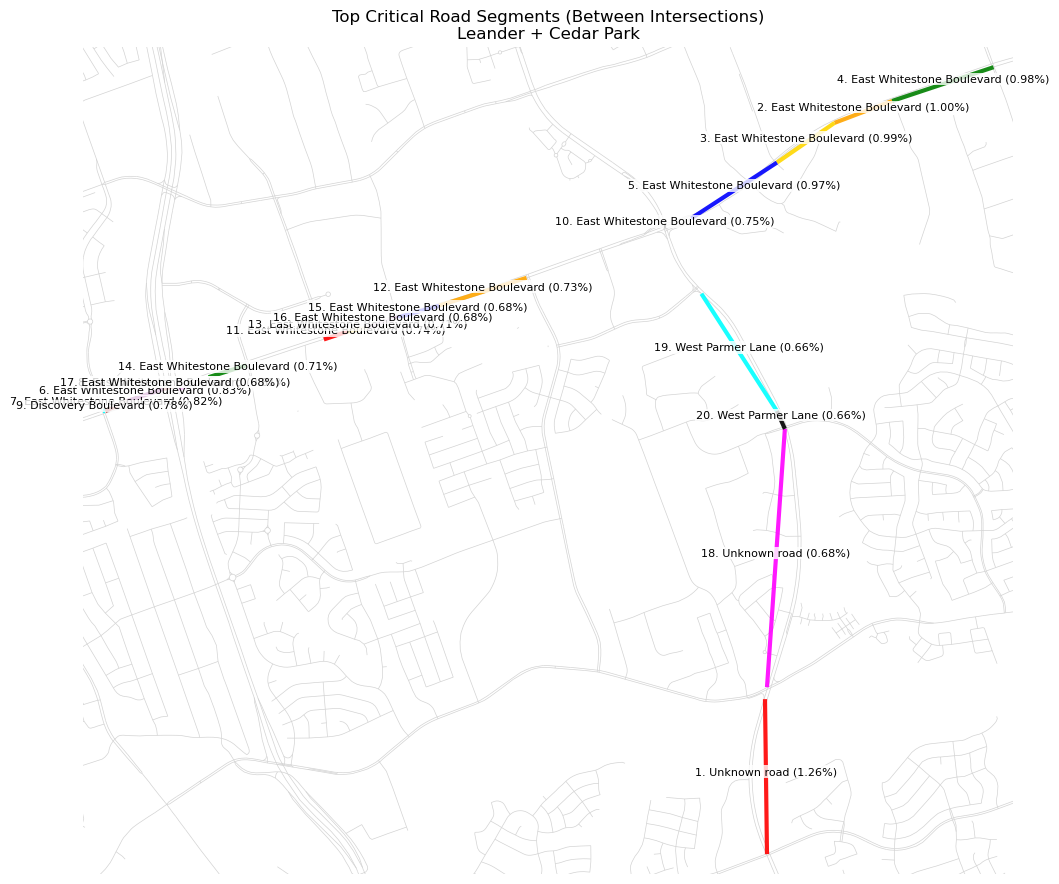

In [25]:
from shapely.geometry import LineString
import matplotlib.pyplot as plt

# How many segments to highlight
k_highlight = 20

crit_edges = (
    edge_impact_cp_lea
    .sort_values("eff_drop_pct", ascending=False)
    .head(k_highlight)
    .copy()
)

# Build actual line geometry between intersections
crit_edges["geometry"] = crit_edges["edge"].apply(
    lambda uv: LineString([uv[0], uv[1]])
)

gdf_crit_edges = gpd.GeoDataFrame(
    crit_edges,
    geometry="geometry",
    crs="EPSG:3857"
)

fig, ax = plt.subplots(figsize=(12, 12))

cp_lea_proj.plot(ax=ax, color="lightgray", linewidth=0.5)

# give each segment a distinct color
colors = [
    "red", "orange", "gold", "green", "blue",
    "purple", "brown", "magenta", "cyan", "black"
]
gdf_crit_edges["rank"] = range(1, len(gdf_crit_edges) + 1)
gdf_crit_edges["color"] = [
    colors[(r - 1) % len(colors)] for r in gdf_crit_edges["rank"]
]

for _, row in gdf_crit_edges.iterrows():
    gpd.GeoDataFrame([row], geometry="geometry", crs="EPSG:3857").plot(
        ax=ax,
        color=row["color"],
        linewidth=3,
        alpha=0.9
    )
    x, y = row.geometry.centroid.x, row.geometry.centroid.y
    label = f"{row['rank']}. {row['road_name']} ({row['eff_drop_pct']:.2f}%)"
    ax.text(
        x, y,
        label,
        fontsize=8,
        ha="center",
        va="bottom",
        bbox=dict(facecolor="white", edgecolor="none", alpha=0.8, pad=1.0)
    )

minx, miny, maxx, maxy = gdf_crit_edges.total_bounds
pad = 150
ax.set_xlim(minx - pad, maxx + pad)
ax.set_ylim(miny - pad, maxy + pad)

ax.set_title("Top Critical Road Segments (Between Intersections)\nLeander + Cedar Park")
ax.set_axis_off()

plt.show()


#### Failure Simulation - How robust is the network against removals?
How quickly does the network collapse under failures?
Does the network degrade slowly or catastrophically when edges fail?
How robust is the system when we remove the top edges vs. random edges

Targeted Edges:
“If an intelligent attacker (or disaster) takes out the most important edges first, how fast does mobility collapse?”

Random edges:
“If failures occur randomly (weather events, construction, accidents), how fast does the system degrade on average?”

In [ ]:
# ========= Failure simulation: targeted vs random edges =========
t0 = time.perf_counter()

def simulate_failure_curves(
    G,
    edge_btw,
    max_remove=10,
    n_runs=10,
    n_pairs=400,
    weight="travel_time_s",
    seed=SEED,
):
    random.seed(seed)
    np.random.seed(seed)

    edges = sorted(G.edges())
    m = len(edges)
    max_remove = min(max_remove, m)

    targeted_edges = [e for e, _ in sorted(edge_btw.items(),
                                           key=lambda x: x[1],
                                           reverse=True)]

    nodes = sorted(G.nodes())
    if len(nodes) < 2:
        raise ValueError("Graph must have at least 2 nodes.")
    pairs = [tuple(random.sample(nodes, 2)) for _ in range(n_pairs)]

    E0 = approximate_efficiency_from_pairs(G, pairs, weight=weight)

    # targeted
    G_tar = G.copy()
    E_targeted = [E0]
    for k in range(1, max_remove + 1):
        e = targeted_edges[k - 1]
        if G_tar.has_edge(*e):
            G_tar.remove_edge(*e)
        E_targeted.append(approximate_efficiency_from_pairs(G_tar, pairs, weight=weight))

    # random
    E_random_all = np.zeros((n_runs, max_remove + 1))
    for r in range(n_runs):
        G_rand = G.copy()
        order = edges.copy()
        np.random.shuffle(order)
        E_random_all[r, 0] = E0
        for k in range(1, max_remove + 1):
            e = order[k - 1]
            if G_rand.has_edge(*e):
                G_rand.remove_edge(*e)
            E_random_all[r, k] = approximate_efficiency_from_pairs(G_rand, pairs, weight=weight)

    E_random_mean = E_random_all.mean(axis=0)
    E_random_std = E_random_all.std(axis=0)
    ks = np.arange(0, max_remove + 1)

    return pd.DataFrame({
        "k_removed": ks,
        "E_targeted": E_targeted,
        "E_random_mean": E_random_mean,
        "E_random_std": E_random_std
    })

failure_curves = simulate_failure_curves(
    G_cp_lea_simpl,
    edge_btw,
    max_remove=10,
    n_runs=15,
    n_pairs=3000
)
t1 = time.perf_counter()
print(f"Centrality section took {t1 - t0:.2f} seconds")

failure_curves.head()


## Leander & Cedar Park - Question 3 Analysis

In [ ]:
#Choose a set of closed edges (damage scenario)
t0 = time.perf_counter()

k_repair = 10

# Top-k edges by betweenness → considered "closed"
closed_edges = [e for e, _ in sorted(edge_btw.items(), key=lambda x: x[1], reverse=True)[:k_repair]]

len(closed_edges), closed_edges[:3]


In [ ]:
#`which closed roads should we fix first, and in what order?
t0 = time.perf_counter()


def greedy_repair_order(
    G_base,
    closed_edges,
    pairs,
    weight="travel_time_s"
):
    """
    Start from G_base with `closed_edges` removed.
    Iteratively reopen the edge that yields the largest efficiency gain.
    Returns a DataFrame with repair order and efficiency gains.
    """
    # Start from damaged graph
    G_damaged = G_base.copy()
    for (u, v) in closed_edges:
        if G_damaged.has_edge(u, v):
            G_damaged.remove_edge(u, v)

    E_damaged = approximate_efficiency_from_pairs(G_damaged, pairs, weight=weight)

    remaining = list(closed_edges)
    repair_results = []

    current_graph = G_damaged
    current_eff = E_damaged

    step = 1
    while remaining:
        best_edge = None
        best_eff = -1.0

        # Try reopening each remaining edge
        for (u, v) in remaining:
            if current_graph.has_edge(u, v):  # already open somehow
                continue
            G_tmp = current_graph.copy()
            # copy attributes from base graph if present
            if G_base.has_edge(u, v):
                data = G_base[u][v]
                G_tmp.add_edge(u, v, **data)
            else:
                # if base doesn't have it (weird), skip
                continue

            E_after = approximate_efficiency_from_pairs(G_tmp, pairs, weight=weight)

            if E_after > best_eff:
                best_eff = E_after
                best_edge = (u, v)

        # Apply best repair
        (bu, bv) = best_edge
        if G_base.has_edge(bu, bv):
            current_graph.add_edge(bu, bv, **G_base[bu][bv])
        current_eff = best_eff

        # Attach road name for interpretation
        road_name = G_base[bu][bv].get("name", "Unknown road")

        gain_pct = (current_eff - E_damaged) / E_damaged * 100 if E_damaged > 0 else 0.0

        repair_results.append({
            "step": step,
            "edge": best_edge,
            "road_name": road_name,
            "efficiency_after": current_eff,
            "gain_pct_vs_damaged": gain_pct
        })

        remaining.remove(best_edge)
        step += 1

    return pd.DataFrame(repair_results)


# Sample pairs for recovery evaluation
pairs_for_recovery = sample_pairs(G_cp_lea_simpl, n_pairs=3000, seed=SEED)

repair_table = greedy_repair_order(
    G_cp_lea_simpl,
    closed_edges,
    pairs_for_recovery,
    weight="travel_time_s"
)

t1 = time.perf_counter()
print(f"Centrality section took {t1 - t0:.2f} seconds")

repair_table
